In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import ipywidgets as widgets

# Load basic science tools
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from numpy.random import rand, randint, uniform, choice, normal 
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [161]:
import plotly.express as px
from numba import jit, njit

### Write main helper function of Molecular dynamics
 
 0. Initialize system (num particles, potentials, box size)
 <br><br>
 1. Set sim parameters (temperature,  thermostat, integration time step, num steps) 
 <br><br>
 2. Evolve velocities by computing forces (via a Verlet Algorithm)
 <br><br>
 3. Enforce PBC, update velocities, positions, observables. 
 <br><br>
 5. repeat 2-3 until target timesteps reached

### Specify initial configuration of the system

In [162]:
#-------Simulation parameters ----

N        = 100      # Try different values
rho      = 0.85     # We set density 
T  = 2
L  =  (N/rho)**(1/3) # Length of the box side

print('Num particles: ', N, '\nBox Length:    ', L)

Num particles:  100 
Box Length:     4.899973050296446


### Initialize positions and velocities

In [163]:
def initialize(N, L):
    
    """Put N particles in a box, 
    using dense packing unit lattice of size n3"""

    pos = np.zeros((N,3))
     
    n3 = int(N **(1/3)) + 1
    iix = iiy = iiz = 0
    
    for i in range(N):
        
        pos[i][0] = (iix + 0.5) * L / n3
        pos[i][1] = (iiy + 0.5) * L / n3
        pos[i][2] = (iiz + 0.5) * L / n3
        
        iix += 1
        
        if iix == n3:
            
            iix  = 0
            iiy += 1
            
            if iiy == n3:
                
                iiy = 0
                iiz += 1 

    # Draw velocities from normal distribution
    vel = np.random.randn(N, 3)
                
    return pos - L/2 , vel - np.mean(vel)

### Visualize lattice and velocities

In [164]:
pos, vel = initialize(N, L)

#px.scatter_3d(x=pos[:,0], y=pos[:,1], z=pos[:,2], opacity=0.5)

### Functions for distances and PBC

In [172]:
@jit
def pbc_wrap(pp, L):
    
    ''' (a) if pp = (x,y,z) position; wraps it back to box (with origin in the center!) 
        (b) if pp = (dr_x, dr_y, dr_z) distances; uses nearest image convension'''
    
    #Using fancy indexing to select points outside of box        
    pp[pp  > L/2]  -= L  
    pp[pp  < -L/2] += L
    
    return pp

### Compute forces, potential energy and pressure

In [173]:
@jit
def force_update(pos, L, sig, eps, trunc):
    
    """Calculate the forces 
    alsoassociated potential energy and pressure"""
    
    N=len(pos)
    
    force = np.zeros((N,N,3))   # Force matrix vector
    pe    = 0.0

    for i in range(N-1):
        for j in range(i+1, N):

            dr  = pos[i]-pos[j]
            dr  = pbc_wrap(dr, L)
            
            dr2 = np.sum(dr**2)
            
            if  dr2 < trunc**2:   
                
                pe    += 4*eps * ( (sig/dr2)**6 - (sig/dr2)**3 )
                
                force[i,j] += -eps  * 48 * ( sig**12 / dr2**7 - 0.5 *sig**6 / dr2**4) * dr
                force[j,i]  = -force[i,j] 
                
    press = np.sum(force * dr)
         
    return force,  pe, press

### Update positions via Verlet algorithm

In [174]:
@jit
def md_update(pos, L, vel, force, dt):
    
    """Verloctiy verlet algorithm for 
    updating positions and velocites over time-step dt"""

    # Convert (N,N,3) force matrix to force acting per particle (N,3) 
    F = np.sum(force, axis=0) - np.sum(force, axis=1)
           
    pos += vel * dt + 0.5* F * dt*dt
    
    vel += 0.5 * F * dt
    
    return pos, vel

### Thermostats to keep T=const

In [175]:
@jit
def therm_simple(vel, T, N):
    
    """Simple thermostat
    Returns new updated velocty and previous kinetic energy and temperature 
    """
    
    KE = 0.5*np.sum(vel**2)
    
    temp = 3.0 * KE / (2.0 * N)
    
    scale = np.sqrt(T/temp)
    
    return vel*scale, KE, temp
    
@jit
def therm_berendsen(vel, T, N, dt=0.001, tau=0.1):
    
    """Berendsen thermostat 
    Returns new updated velocty and previous kinetic energy and temperature 
    """
    
    KE    = 0.5*np.sum(vel**2)
    
    temp  = 3.0 * KE / (2.0 * N)
    
    scale = np.sqrt(1 + dt / tau * (T / (2.0 * KE / 3.0 / N) - 1.0))
    
    return vel*scale, KE, temp

### Main MD engine

In [185]:
@jit
def mdrun(pos, vel, L, T=1, sig=1, eps=1, trunc=3, dt=0.001, steps = 10000, freq = 1000):
    
    """The main MD function"""
    
    conf_PE, conf_KE, conf_temp, conf_press = [],[],[],[]
    conf   = []
    
    for step in range(steps):
        
        pos = pbc_wrap(pos, L)
        
        force, PE, press      = force_update(pos, L, sig, eps, trunc)
        
        pos, vel              = md_update(pos, L,  vel, force,  dt)

        vel, KE, temp = therm_simple(vel, T, N)
        
        #Record observables
        if step % freq ==0:
            
            print(100*(step+1)/steps, " % done")
            conf_PE.append(PE)
            conf_KE.append(KE)
            conf_temp.append(temp)
            conf_press.append(press)
            conf.append(pos.copy())
        
    return np.array(conf_PE), np.array(conf_KE), np.array(conf_temp), np.array(conf_press) , np.array(conf)

In [186]:
#-------Simulation parameters ----
N        = 100      # Try different values
T        = 0.7      # Try different values
rho      = 0.85     # We set density 
L        =  (N/rho)**(1/3) # Length of the box side

pos, vel = initialize(N, L)

In [187]:
%time 
data = mdrun(pos, vel, L, T, sig=1, eps=1, trunc=3, dt=0.001, steps=10000, freq=100)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
0.01  % done
1.01  % done
2.01  % done
3.01  % done
4.01  % done
5.01  % done
6.01  % done
7.01  % done
8.01  % done
9.01  % done
10.01  % done
11.01  % done
12.01  % done
13.01  % done
14.01  % done
15.01  % done
16.01  % done
17.01  % done
18.01  % done
19.01  % done
20.01  % done
21.01  % done
22.01  % done
23.01  % done
24.01  % done
25.01  % done
26.01  % done
27.01  % done
28.01  % done
29.01  % done
30.01  % done
31.01  % done
32.01  % done
33.01  % done
34.01  % done
35.01  % done
36.01  % done
37.01  % done
38.01  % done
39.01  % done
40.01  % done
41.01  % done
42.01  % done
43.01  % done
44.01  % done
45.01  % done
46.01  % done
47.01  % done
48.01  % done
49.01  % done
50.01  % done
51.01  % done
52.01  % done
53.01  % done
54.01  % done
55.01  % done
56.01  % done
57.01  % done
58.01  % done
59.01  % done
60.01  % done
61.01  % done
62.01  % done
63.01  % done
64.01  % done
65.01  % done
66.01  % done
67.01  %

### Visualize output

Text(0.5, 0, 'time steps')

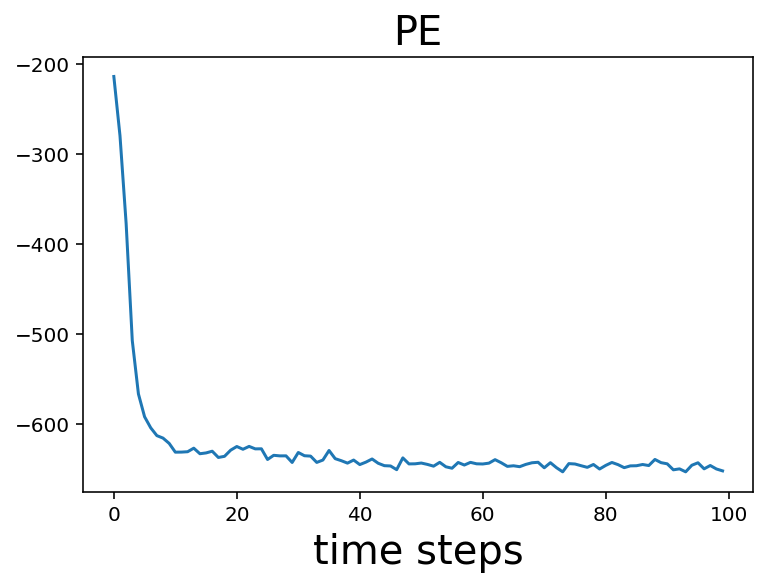

In [188]:
plt.plot(data[0])
plt.title('PE',fontsize=20)
plt.xlabel('time steps',fontsize=20)

Text(0.5, 0, 'time steps')

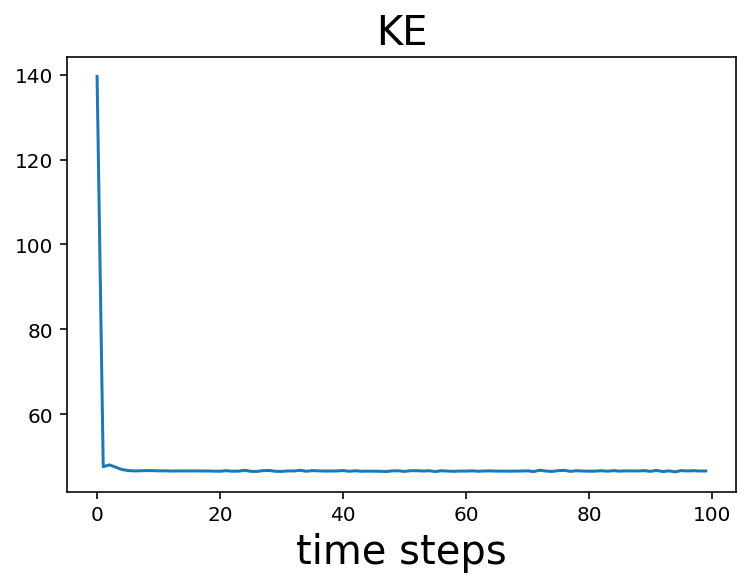

In [189]:
plt.plot(data[1])
plt.title('KE',fontsize=20)
plt.xlabel('time steps',fontsize=20)

Text(0.5, 0, 'time steps')

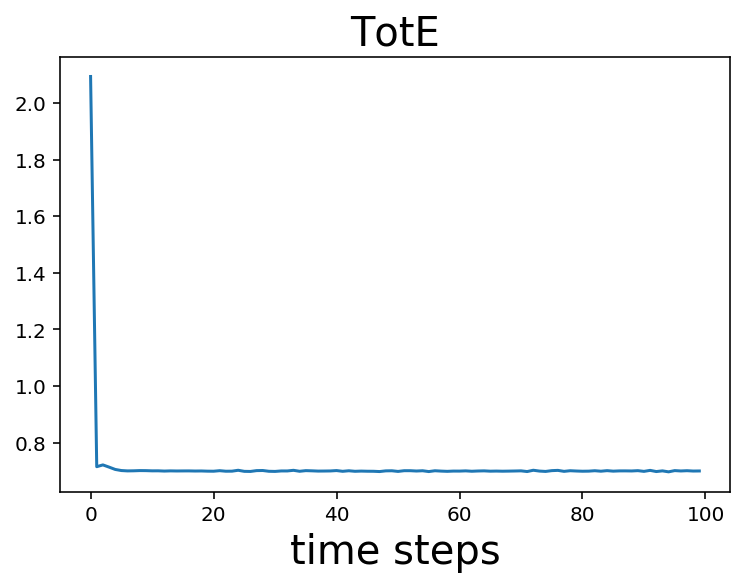

In [190]:
plt.plot(data[2])
plt.title('TotE',fontsize=20)
plt.xlabel('time steps',fontsize=20)

In [192]:
pos = data[4][10]
px.scatter_3d(x=pos[:,0], y=pos[:,1], z=pos[:,2], opacity=0.5)